# AGENT PERFORMANCE GRADING: OPTIMIZING CUSTOMER SERVICE

# Install Necessary Libraries

In [ ]:
!pip install pandas numpy nltk sklearn vaderSentiment spacy
!python -m spacy download en_core_web_sm

In [ ]:
pip install vaderSentiment

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load and Prepare Data

In [3]:
data = pd.DataFrame({
    'agent_id': [1, 2, 1, 2, 3, 1, 2, 3, 1, 2] * 10,
    'customer_id': [101, 102, 103, 104, 105, 106, 107, 108, 109, 110] * 10,
    'text': [
        "The product delivery was delayed... I'm very disappointed!!!",
        "Thank you for the quick response and resolution. :)",
        "I still haven't received my order!!! This is frustrating...",
        "Excellent service and very helpful support!",
        "The issue was resolved promptly. Great job!! :-)",
        "Why is my order still pending? I need it urgently!",
        "Your service is amazing, keep it up!",
        "I'm not happy with the delay in your service.",
        "Can you please expedite my order delivery?",
        "Great customer support, thank you!"
    ] * 10,
    'resolved': [0, 1, 0, 1, 1, 0, 1, 0, 0, 1] * 10,
    'response_time': [300, 50, 400, 30, 60, 500, 20, 350, 450, 25] * 10,
    'customer_feedback': [
        "negative", "positive", "negative", "positive", "positive",
        "negative", "positive", "negative", "negative", "positive"
    ] * 10
})

In [4]:
data

,agent_id,customer_id,text,resolved,response_time,customer_feedback
0,1,101,The product delivery was delayed... I'm very d...,0,300,negative
1,2,102,Thank you for the quick response and resolutio...,1,50,positive
2,1,103,I still haven't received my order!!! This is f...,0,400,negative
3,2,104,Excellent service and very helpful support!,1,30,positive
4,3,105,The issue was resolved promptly. Great job!! :-),1,60,positive
...,...,...,...,...,...,...
95,1,106,Why is my order still pending? I need it urgen...,0,500,negative
96,2,107,"Your service is amazing, keep it up!",1,20,positive
97,3,108,I'm not happy with the delay in your service.,0,350,negative
98,1,109,Can you please expedite my order delivery?,0,450,negative


# Data Preprocessing

In [5]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text.strip()

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.lower() not in stop_words]
    return tokens

data['clean_text'] = data['text'].apply(clean_text)
data['tokens'] = data['clean_text'].apply(tokenize_and_remove_stopwords)
print(data[['text', 'clean_text', 'tokens']])


                                                 text  \
0   The product delivery was delayed... I'm very d...   
1   Thank you for the quick response and resolutio...   
2   I still haven't received my order!!! This is f...   
3         Excellent service and very helpful support!   
4    The issue was resolved promptly. Great job!! :-)   
..                                                ...   
95  Why is my order still pending? I need it urgen...   
96               Your service is amazing, keep it up!   
97      I'm not happy with the delay in your service.   
98         Can you please expedite my order delivery?   
99                 Great customer support, thank you!   

                                           clean_text  \
0   the product delivery was delayed im very disap...   
1     thank you for the quick response and resolution   
2   i still havent received my order this is frust...   
3          excellent service and very helpful support   
4           the issue was reso

# Sentiment Analysis

In [6]:
analyzer = SentimentIntensityAnalyzer()
data['sentiment'] = data['clean_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
print(data[['text', 'sentiment']])


                                                 text  sentiment
0   The product delivery was delayed... I'm very d...    -0.6478
1   Thank you for the quick response and resolutio...     0.3612
2   I still haven't received my order!!! This is f...    -0.4404
3         Excellent service and very helpful support!     0.8680
4    The issue was resolved promptly. Great job!! :-)     0.7003
..                                                ...        ...
95  Why is my order still pending? I need it urgen...     0.0000
96               Your service is amazing, keep it up!     0.5859
97      I'm not happy with the delay in your service.    -0.6483
98         Can you please expedite my order delivery?     0.3182
99                 Great customer support, thank you!     0.8519

[100 rows x 2 columns]


# Keyword Extraction using TF-IDF

In [7]:
vectorizer = TfidfVectorizer(max_features=10)
tfidf_matrix = vectorizer.fit_transform(data['clean_text'])
data['tfidf'] = list(tfidf_matrix.toarray())
print(data[['text', 'tfidf']])


                                                 text  \
0   The product delivery was delayed... I'm very d...   
1   Thank you for the quick response and resolutio...   
2   I still haven't received my order!!! This is f...   
3         Excellent service and very helpful support!   
4    The issue was resolved promptly. Great job!! :-)   
..                                                ...   
95  Why is my order still pending? I need it urgen...   
96               Your service is amazing, keep it up!   
97      I'm not happy with the delay in your service.   
98         Can you please expedite my order delivery?   
99                 Great customer support, thank you!   

                                                tfidf  
0   [0.8039456888755269, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.65714454...  
2   [0.0, 0.5773502691896257, 0.0, 0.5773502691896...  
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.6469808613753582, ...  
4   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

# Named Entity Recognition (NER)

In [8]:
nlp = spacy.load('en_core_web_sm')
def recognize_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

data['entities'] = data['clean_text'].apply(recognize_entities)
print(data[['text', 'entities']])


                                                 text entities
0   The product delivery was delayed... I'm very d...       []
1   Thank you for the quick response and resolutio...       []
2   I still haven't received my order!!! This is f...       []
3         Excellent service and very helpful support!       []
4    The issue was resolved promptly. Great job!! :-)       []
..                                                ...      ...
95  Why is my order still pending? I need it urgen...       []
96               Your service is amazing, keep it up!       []
97      I'm not happy with the delay in your service.       []
98         Can you please expedite my order delivery?       []
99                 Great customer support, thank you!       []

[100 rows x 2 columns]


# Model Training

In [9]:
# Combine features for training
features = np.concatenate((tfidf_matrix.toarray(), data[['sentiment', 'response_time']].values), axis=1)
labels = data['resolved']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=2)

y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Best Parameters: {best_params}")
print(f"Cross-validation Scores: {cv_scores}")
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Cross-validation Scores: [1. 1.]
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



# Scoring and Ranking Agents

In [10]:
data['composite_score'] = (
    0.3 * data['sentiment'] +
    0.3 * data['resolved'] +
    0.2 * (1 / data['response_time']) +
    0.2 * (data['customer_feedback'] == 'positive').astype(int)
)

agent_scores = data.groupby('agent_id')['composite_score'].mean().sort_values(ascending=False)
print("Agent Scores:\n", agent_scores)


Agent Scores:
 agent_id
2    0.707192
3    0.259752
1   -0.057247
Name: composite_score, dtype: float64


In [19]:
agent_scores = {
    'Agent 1': -0.057247,
    'Agent 2': 0.707192,
    'Agent 3': 0.259752
}

# Visualization

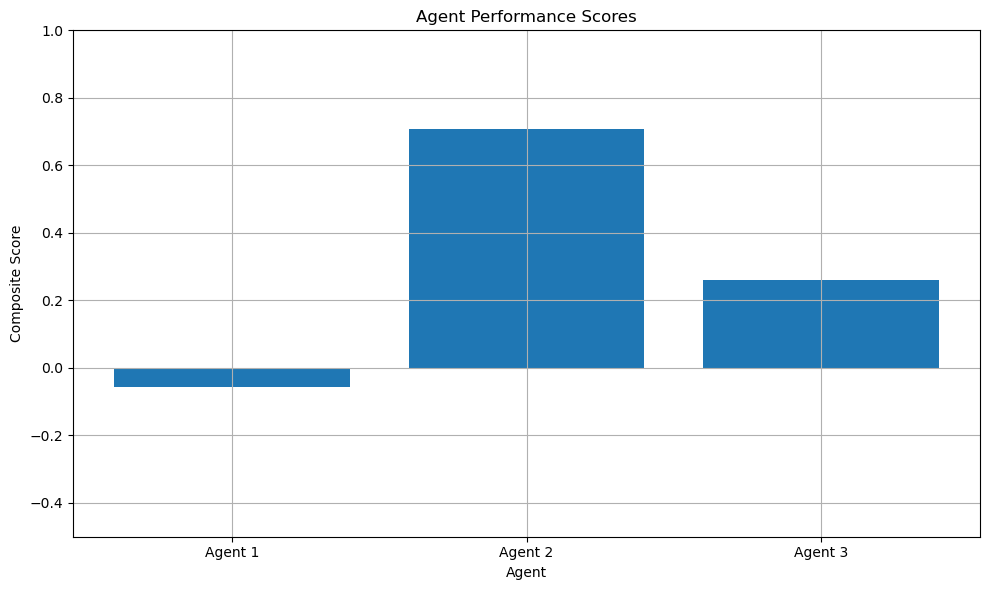

In [24]:
# Convert data to lists for plotting
agents = list(agent_scores.keys())
scores = list(agent_scores.values())

plt.figure(figsize=(10, 6))
plt.bar(agents, scores, capsize=5)
plt.xlabel('Agent')
plt.ylabel('Composite Score')
plt.title('Agent Performance Scores')
plt.ylim(-0.5, 1.0)  
plt.grid(True)
plt.tight_layout()
plt.show()